# Sentiment Classification

Project investigating NLP methods for distinguishing positive and negative reviews written about movies.

In [1]:
seed_num=462488

In [2]:
#do not change the code in this cell
#preliminary imports

#set up nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('movie_reviews')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import movie_reviews

#for setting up training and testing data
import random

#useful other tools
import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import zip_longest
from nltk.probability import FreqDist
from nltk.classify.api import ClassifierI


[nltk_data] Downloading package punkt to /home/poppy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/poppy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /home/poppy/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


In [3]:
def split_data(data, ratio=0.7): # when the second argument is not given, it defaults to 0.7
    """
    Given corpus generator and ratio:
     - partitions the corpus into training data and test data, where the proportion in train is ratio,

    :param data: A corpus generator.
    :param ratio: The proportion of training documents (default 0.7)
    :return: a pair (tuple) of lists where the first element of the 
            pair is a list of the training data and the second is a list of the test data.
    """
    
    data = list(data)  
    n = len(data)  
    train_indices = random.sample(range(n), int(n * ratio))          
    test_indices = list(set(range(n)) - set(train_indices))    
    train = [data[i] for i in train_indices]           
    test = [data[i] for i in test_indices]             
    return (train, test)                       
 

def get_train_test_data():
    
    #get ids of positive and negative movie reviews
    pos_review_ids=movie_reviews.fileids('pos')
    neg_review_ids=movie_reviews.fileids('neg')
   
    #split positive and negative data into training and testing sets
    pos_train_ids, pos_test_ids = split_data(pos_review_ids)
    neg_train_ids, neg_test_ids = split_data(neg_review_ids)
    #add labels to the data and concatenate
    training = [(movie_reviews.words(f),'pos') for f in pos_train_ids]+[(movie_reviews.words(f),'neg') for f in neg_train_ids]
    testing = [(movie_reviews.words(f),'pos') for f in pos_test_ids]+[(movie_reviews.words(f),'neg') for f in neg_test_ids]
   
    return training, testing

When you have run the cell below, your unique training and testing samples will be stored in `training_data` and `testing_data`

In [4]:
#do not change the code in this cell
random.seed(seed_num)
training_data,testing_data=get_train_test_data()
print("The amount of training data is {}".format(len(training_data)))
print("The amount of testing data is {}".format(len(testing_data)))
print("The representation of a single data item is below")
print(training_data[0])

The amount of training data is 1400
The amount of testing data is 600
The representation of a single data item is below
(['the', 'party', 'is', 'one', 'of', 'those', 'classic', ...], 'pos')


## Part 1   

a) **Generation** of a list of 10 content words which are representative of the positive reviews in the training data.

b) **Generation** of a list of 10 content words which are representative of the negative reviews in the training data.

c) **Explanation** of what I have done and why

In [5]:
#first I want to normalise my training data...

from nltk.stem.wordnet import WordNetLemmatizer


def punct_norm(data_set):
    punct = '''!()-[]{};:--'"\, <>./?@#$%^&*_~'''
    normalised_data = []
    for review_pair in data_set:
        filtered_tokens = []
        for token in list(review_pair[0]):
            if token not in punct:
                filtered_tokens.append(token)
        normalised_data.append((filtered_tokens, review_pair[1]))
    return normalised_data

def num_norm(data_set):
    normalised_data = []
    for review_pair in data_set:
        filtered_tokens = (["NUM" if token.isdigit() else token for token in list(review_pair[0])])
        filtered_tokens = (["Nth" if not token.isalpha() and token.endswith(("th","rd","nd","st")) else token for token in filtered_tokens])
        normalised_data.append((filtered_tokens, review_pair[1]))
    return normalised_data

def lemmatize(data_set):
    lem = WordNetLemmatizer()
    normalised_data = []
    for review_pair in data_set:
        filtered_tokens = []
        for token in list(review_pair[0]):
            filtered_tokens.append(lem.lemmatize(token))
        normalised_data.append((filtered_tokens, review_pair[1]))
    return normalised_data

def remove_stop_words(data_set):
    keyword_list = ["the"]
    stop = stopwords.words('english') 
    normalised_data = []
    for review_pair in data_set:
        filtered_tokens = []
        for token in list(review_pair[0]):
            if token in stop or token in keyword_list:
                pass
            else:
                filtered_tokens.append(token)
        normalised_data.append((filtered_tokens, review_pair[1]))
    return normalised_data

def normalise(data):
    norm = punct_norm(data)
    norm = num_norm(norm)
    norm = remove_stop_words(norm)
    norm = lemmatize(norm)
    return norm

training_norm = normalise(training_data)
testing_norm = normalise(testing_data)

In [6]:
#next get the frequency distributions from data

def get_frequency_dists(training_data):
    pos_freq_dist=FreqDist()
    neg_freq_dist=FreqDist()
    for reviewDist,label in training_data:
        if label=='pos':
            pos_freq_dist+=FreqDist(reviewDist)
        else:
            neg_freq_dist+=FreqDist(reviewDist)
    return pos_freq_dist, neg_freq_dist
    
pos_freq_dist, neg_freq_dist = get_frequency_dists(training_norm)

In [7]:
#then get the greatest frequency difference relative to the other distribution

def most_frequent_words(fd1, fd2, k):
    more_freq = FreqDist()
    for word in fd1.keys():
        if word in fd2:
            more_freq[word] = fd1[word] - fd2[word]
        else:
            more_freq[word] = fd1[word]
    return dict(more_freq.most_common(k))


pos_word_list = most_frequent_words(pos_freq_dist, neg_freq_dist, 10)
neg_word_list = most_frequent_words(neg_freq_dist, pos_freq_dist, 10)

In [8]:
positive_wl = pd.DataFrame(pos_word_list.items(), columns=["Word", "Freq"])
positive_wl.style.set_table_attributes("style = 'displaye:inline'").set_caption("1. a) Positive Word List")

,Word,Freq
0,film,886
1,life,429
2,also,366
3,one,326
4,story,306
5,well,287
6,great,285
7,performance,262
8,world,248
9,many,221


In [9]:
negative_wl = pd.DataFrame(neg_word_list.items(), columns=["Word", "Freq"])
negative_wl.style.set_table_attributes("style = 'displaye:inline'").set_caption("1. b) Negative Word List")

,Word,Freq
0,bad,476
1,movie,449
2,plot,205
3,minute,145
4,worst,142
5,could,115
6,attempt,109
7,script,107
8,boring,105
9,big,101


Type Markdown and LaTeX:  𝛼2

### 1. c)

PART 1. NORMALISATION

The first step is to normalise the training and testing data, labelled training_norm and testing_norm. The reason for this is to reduce the documents to just their most key features which are most informative for the purpose of classifying the documents as either positive or negative.

The data was already case normalised to lower case, so I chose to normalise by removing all of the punctuation and special characters, converting all numbers into ‘NUM’ (as well as ‘Nth’ for ‘1st’, ‘2nd’ etc). This is because actual contents of the numbers are not particularly indicative of positive or negative sentiment, and this helps remove some of the words that only occur once in our corpus (known as hapax legonoma).

I chose to then reduce the vocabulary size further by lemmatizing (using the NLTK lemmatizer) in order to reduce words down to their root form (meaning ‘films’ would become ‘film’ etc), which further helps to concentrate the text into a collection of more homogenous important features. I chose lemmatizing over stemming as stemming just chops off the last few letters of the word often producing incorrect meanings.

I also removed stop words (very common so-called function words such as ‘a’ and ‘is’) which don’t carry much meaning in the context of positive and negative sentiment analysis therefore it is safe to say that we want to ignore them, and well as removing the word ‘the’ (as was not in nltk stop word list).

PART 2. GREATEST FREQUENCY DIFFERENCE

In order to see the relative importance of each feature (word) in the document collection, we can find the frequency of the occurrence of each word. This involved going through each labelled class of document (‘pos’ or ‘neg’) and putting all of the words into a single frequency distribution for each class (using FreqDist from nltk.probability). This gives a list of an ordered frequency distribution for the features in positive reviews and the features in negative reviews.

The final step was to then get the most frequent words from each distribution relative to the other distribution (so the greatest frequency difference). It is important that it is the highest scoring relative to the other as we want the document features that most uniquely represent that class in the context of all classes.

The function most_frequent_words has 3 parameters, two of which are frequency distributions (in this case we will pass our in our positive and negative FreqDists) and the third a natural number k which will tell us how many of the top scoring words we want to return. I then called this function twice, first for positive relative to negative and second for negative relative to positive producing a list of the top 10 words most representative of my positive and negative reviews respectively. I chose to return the top most frequent words as opposed the top words above a certain frequency threshold as this latter method returns very unbalanced list sizes (the positive list was much longer than the negative list) therefore this would have led to the introduction of a bias towards classifying reviews as positive when using these lists below in question 2.


## Part 2
a) **Using** the lists generated in part 1 to build a **word list classifier** which will classify reviews as being positive or negative.

b) **Explanation** of what I have done and why


In [10]:
from nltk.classify.api import ClassifierI
import random

class WordListClassifier(ClassifierI): 

    def __init__(self, pos, neg): 
        self.pos = pos 
        self.neg = neg 

    def classify(self, words): 
        score = 0
        for word in words:
            if word in self.pos:
                score = score + 1
            elif word in self.neg:
                score = score - 1
        if score == 0:
            score = random.choice([-1, 1])
        return "neg" if score < 0 else "pos"
    
    def labels(self): 
        return ("pos", "neg")

In [11]:
classifier = WordListClassifier(pos_word_list, neg_word_list)

Type Markdown and LaTeX:  𝛼2

### 2. b)

My classifier inherits from ClassifierI which I imported (meaning that it inherits the classify_many method). The classifier is initialised with two arguments, a positive and a negative word list (in this case I use the top 10 most representative words from each class created above.

It has a classify method which goes through each word in a document and adds 1 to the score if it encounters a word in the positive list and subtracts 1 if it encounters a word from the negative list. It returns negative if the final score comes out as less than zero and positive if more than zero, as this is indicative of the total number of words from each it has come across. If the score is zero (i.e. it has come across an equal number of positive and negative words), then it just randomly assigns it either a -1 or 1 (so just guesses ‘pos’ or ‘neg’ at random). It also has a labels method which returns the classification labels.

## Part 3
a) **Calculating** the accuracy, precision, recall and F1 score of the classifier.

b) **Explanation** of why it is reasonable to evaluate the classifier in terms of its accuracy.

In [12]:
class ConfusionMatrix:
    def __init__(self,predictions,goldstandard,classes=("pos","neg")): 
        
        (self.c1,self.c2) = classes
        
        self.TP=0
        self.FP=0
        self.FN=0
        self.TN=0
        for p,g in zip(predictions,goldstandard):
            
            if g==self.c1:
                if p==self.c1:
                    self.TP = self.TP + 1
                else:
                    self.FN = self.FN + 1
                    
            elif p==self.c1:
                self.FP = self.FP + 1
            else:
                self.TN = self.TN + 1     
    
    def precision(self):
        p = 0
        p = self.TP / (self.TP + self.FP)
        return p
  
    def recall(self):
        r = 0
        r = self.TP / (self.TP + self.FN)
        return r
  
    def f1(self):
        f1=0
        f1 = 2 * ((self.precision() * self.recall()) / (self.precision() + self.recall()))
        return f1 

In [13]:
def classifier_evaluate(cls, test_data):
    '''
    cls: an instance of a classifier object which has a classify method which returns "pos" or "neg"
    test_data: a list of pairs where each pair is a FreqDist rep of a doc and its label
  
    returns: float point number which is the accuracy of the classifier on the test data provided 
    '''
    acc = 0
    docs,goldstandard=zip(*test_data) #note this neat pythonic way of turning a list of pairs into a pair of lists
    #pass all of the docs to the classifier and get back a list of predictions
    predictions=cls.classify_many(docs)
    #zip the predictions with the goldstandard labels and compare
    for prediction,goldlabel in zip(predictions,goldstandard):
        if prediction==goldlabel:
            acc+=1
    
    return acc / (len(test_data))

In [14]:
def get_metrics(classifier, testing_data):
    test_data = list(zip(*testing_data))
    pred = classifier.classify_many(test_data[0])
    gold_st = test_data[1]
    matrix = ConfusionMatrix(pred, gold_st)
    precision = matrix.precision()
    recall = matrix.recall()
    f1_score = matrix.f1()
    accuracy = classifier_evaluate(classifier, testing_data)
    list_metrics = [accuracy, precision, recall, f1_score]
    return list_metrics

In [15]:
metrics = pd.DataFrame(get_metrics(WordListClassifier(pos_word_list, neg_word_list), testing_norm), ["Accuracy","Precision","Recall","F1"], columns=["Score"])
metrics.style.set_table_attributes("style = 'displaye:inline'").set_caption("3. a) Evaluation Metrics for Word List Classifier")

,Score
Accuracy,0.588333
Precision,0.567391
Recall,0.870000
F1,0.686842


### 3. b)

The accuracy involves calculating what proportion of the testing data was correctly classified (i.e. it gave the same answer as the gold standard label). This measure can be very misleading if you have unbalanced classes in the data that you are testing on. However, in this case assessing the classifier in terms of its accuracy is a reasonable choice of evaluation metric given that we know that the number of truly positive and truly negative reviews are equal (300 in each class). In addition to this the consequence of prediction errors are not particularly detrimental either, making this metric justifiable. 

An example of when accuracy would be a misleading evaluation metric would be where you might have severely unbalanced classes. For instance, if you had a classifier that was perfect at classifying a certain class of which 95% of the test set were in that class, yet very poor at classifying the other class, you would still get an accuracy of 95%, which is a misleading measure. This is is a serious problem in certain contexts, say the diagnosis of benign and malignant tumors from medical scans. Perhaps you have a classifier that is very good at correctly predicting benign tumors (of which perhaps 99% of cases are) and very poor at correctly identifying cancerous tumors; this would lead to the misleading fact that the classifier is 99% accurate, and potentially lead to harmful misdiagnoses.

## Part 4
a)  **Construction** of a Naive Bayes classifier

b)  **Comparison** of the performance of the word list classifier with the Naive Bayes classifier.

In [16]:
#put the data in the right format for the naive classifier to learn from

def dict_for_each_review(review):
    word_freq_dict = FreqDist()
    for word in review:
        if word in word_freq_dict.keys():
            word_freq_dict[word] = word_freq_dict[word] + 1
        else:
            word_freq_dict[word] = 1
    return word_freq_dict

def format_data(data):
    new_data = []
    for tuple_pair in data:
        new_data.append((dict_for_each_review(tuple_pair[0]), tuple_pair[1]))
    return new_data

training_nb = format_data(training_norm)
testing_nb = format_data(testing_norm)

In [17]:
from nltk.classify import NaiveBayesClassifier
nltk_nb=NaiveBayesClassifier.train(training_nb)

In [18]:
metrics2 = pd.DataFrame(get_metrics(nltk_nb, testing_nb), ["Accuracy","Precision","Recall","F1"], columns=["Score"])
metrics2.style.set_table_attributes("style = 'displaye:inline'").set_caption("4. b) Evaluation Metrics for NLTK Naive Bayes Classifier")

,Score
Accuracy,0.633333
Precision,0.577519
Recall,0.993333
F1,0.730392


### 4. b)

Overall, the naive bayes (NB) classifier consistently performed better on all 4 metrics than my wordlist classifier, with recall being the most significantly better metric (with an improvement of 12.3%). The the accuracy of the NB clasifier was 63.3% over 58.8% for my classifier. The precision was only 1.0% better, however the superior recall measure contributed most to to the improved f1 score of 73.0% (copared to 68.7%).

Given the results for precision and recall for my classifier, it seems as though it is much more likely to classify things as positive than it should do. It is good at identifying correctly identifying reviews in the positive class as being positive, reflected in the (relatively) high recall rate, however the precision is only just above 50% meaning that many of the positive class predictions where incorrectly for the negative class.

The reason for this may be due to a frequency imbalance between the top 10 most representative words for positive and negative (the frequencies of the positive wordlist that I derived are on the whole greater than in the negative wordlist, introducing a bias to my classifier). Naive Bayes classification on the other hand, does not suffer from the problem as it is based on probability of the observed features given the class. 

## Part 5
a) **Experiment** into the impact of the **length of the wordlists** on the wordlist classifier. Includes **design decisions**, a **graph** of my results and **discussion** of conclusions. 

b) **Commentary** a wordlist classifier and Naive Bayes classifier as well as future work in this area


In [19]:
import numpy as np
import matplotlib.pyplot as plt


In [20]:
def iter_metrics(rang):
    precisions = []
    recalls = []
    f1s = []
    for i in rang:
        pos_word_list = most_frequent_words(pos_freq_dist, neg_freq_dist, i)
        neg_word_list = most_frequent_words(neg_freq_dist, pos_freq_dist, i)

        accuracy, precision, recall, f1 = get_metrics(WordListClassifier(pos_word_list, neg_word_list), testing_norm)
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)

    precision_ar = np.array(precisions)
    recall_ar = np.array(recalls)
    f1_ar = np.array(f1s)

    return precision_ar, recall_ar, f1_ar

def plot_metrics(rang, p, r, f1):
    #first graph
    plt.plot(rang, p, label = "Precision")
    plt.title("A) Effect of Word List Length on Classifier Performance")
    plt.xlabel("Word list length")
    plt.ylabel("Score")
    plt.plot(rang, r, label = "Recall")
    plt.plot(rang, f1, label = "F1")
    plt.legend(loc="center right")
    plt.show()
    
    #second graph
    plt.plot(rang, f1)
    plt.title("B) Effect of Word List Length on F1")
    plt.xlabel("Wordlist length")
    plt.ylabel("F1 Score")
    plt.show()
    
    #max values
    print("Max precision:", format(np.max(p),".4f"))
    print("Max recall:", format(np.max(r),".4f"))
    print("Max f1:", format(np.max(f1),".4f"))

    
    return None
    


In [21]:
precision_ar, recall_ar, f1_ar = iter_metrics(range(1, 500, 5))

In [22]:
def iter_wordlist_sums(rang):
    pos = []
    neg = []
    for i in rang:
        pos_word_list = most_frequent_words(pos_freq_dist, neg_freq_dist, i)
        neg_word_list = most_frequent_words(neg_freq_dist, pos_freq_dist, i)
        pos.append(sum(pos_word_list.values()))
        neg.append(sum(neg_word_list.values()))
    ratio = np.array(pos) / np.array(neg)
    mean_ratio = np.mean(ratio)
    return mean_ratio

adjust = iter_wordlist_sums(range(1, 500, 5))

In [23]:
def iter_metrics_adjusted(rang):
    precisions = []
    recalls = []
    f1s = []
    for i in rang:
        pos_word_list = most_frequent_words(pos_freq_dist, neg_freq_dist, i)
        neg_word_list = most_frequent_words(neg_freq_dist, pos_freq_dist, (i * round(adjust))) #adjusted for unblanaced class

        accuracy, precision, recall, f1 = get_metrics(WordListClassifier(pos_word_list, neg_word_list), testing_norm)
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)

    precision_ar = np.array(precisions)
    recall_ar = np.array(recalls)
    f1_ar = np.array(f1s)
    
    return precision_ar, recall_ar, f1_ar

In [24]:
precision_ar2, recall_ar2, f1_ar2 = iter_metrics_adjusted(range(1, 500, 5))

### 5. a)

Design

Part 1:

I decided to investigate what would happen to precision and recall measures (which can be combined and summarised further by the f1 score) when the word list length is gradually increased. I therefore chose to iteratively plot what happened to these metrics as I gradually increased the value of k from 1 to 500 words (in order to sample a large range to provide a comprehensive overview) in steps of 5 (to ensure significantly high resolution in the plotted graph). 


Figure 1


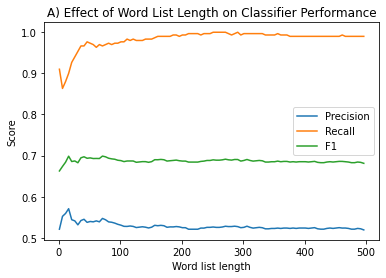

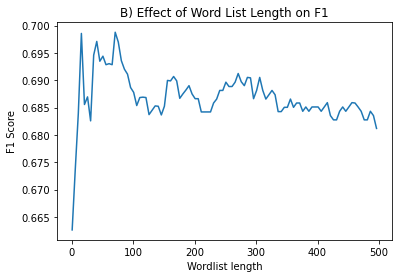

Max precision: 0.5708
Max recall: 1.0000
Max f1: 0.6988


In [25]:
print("Figure 1")
plot_metrics(range(1, 500, 5), precision_ar, recall_ar, f1_ar)

Results

Part 1:

Figure 1a shows that indeed recall does improve as the word list length increases, however, it  reaching a maximum of 100% at 256 words, before slightly reducing in performance (but remaining close to this maximum value) up to 500 words. Precision, on the other hand reaches a maximum (57.1%) much sooner at 21 words and gradually drops from this value with increases in word list length making little difference to precision. 

Figure 1b more clearly shows the f1 score, which takes into account both precision and recall measures, which for my classifier peaks at 69.8% at 80 words. This can therefore be seen as the optimal word list length for classifier performance.


Part 2:

As discussed in question 4b, given that the precision for my original classifier (with the top 10 words in each list) is only just over 57% while the recall is (relatively) high (87%), it suggests that there is a strong bias towards classifying reviews of a particular category. I hypothesised that this may be due to the fact that my method for classifying words was based on frequency of one distribution relative to another however when tallying up the total frequency for the top 10 positive words (total_10_pos, total_10_neg), it was significantly higher than the top 10 negative words. This would be a source of bias towards classifying reviews as positive as, although a certain word may be more frequent in negative than the positive list, it will come across positive list words overall more regularly.

In [26]:
total_10_pos = sum(pos_word_list.values())
total_10_neg = sum(neg_word_list.values())
print(total_10_pos, total_10_neg)

3616 1954


Design

I therefore decided to perform a second experiment which (as in part 1) varies k over 500 words, while ensuring that this ratio between the two word lists during each iterative plot of the metrics value was corrected for by multiplying the value of k by the mean average of the word list difference, essentially crudely adjusting for this disparity. Then, by comparing these results to my unadjusted experiment in part 1, any improvement in performance can be evaluated.

Figure 2:


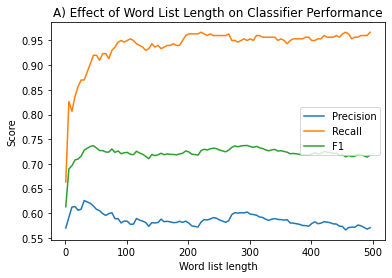

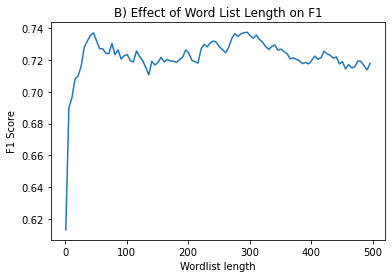

Max precision: 0.6259
Max recall: 0.9667
Max f1: 0.7374
Second Peak: 0.7371


In [27]:
print("Figure 2:")
plot_metrics(range(1, 500, 5), precision_ar2, recall_ar2, f1_ar2)
print("Second Peak:", format(np.unique(f1_ar2)[-2], ".4f"))

Figure 3:


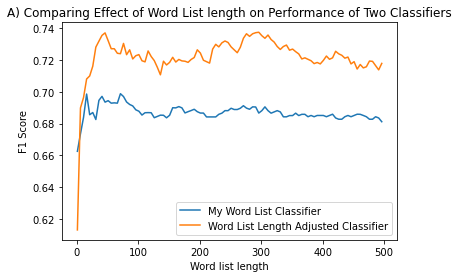

In [28]:
print("Figure 3:")
plt.plot(range(1, 500, 5), f1_ar, label = "My Word List Classifier")
plt.plot(range(1, 500, 5), f1_ar2, label = "Word List Length Adjusted Classifier")
plt.xlabel("Word list length")
plt.ylabel("F1 Score")
plt.legend(loc="best")
plt.title("A) Comparing Effect of Word List length on Performance of Two Classifiers")
plt.show()

Results

Indeed, as Figure 2a and 2b show, while the maximum recall is compromised slightly (reduced to 96.7%), the precision and f1 score are greatly improved upon (by 5.5% and 3.9% respectively) when wordlist length differences are adjusted for. Figure 3a compares the f1 scores of the original and the word list length adjusted classifier and clearly shows the 3.9% improvement that this correction for word list frequency discrepancy made. It reaches this maximum later on however, at 301 words, which can be seen as the optimal wordlist length for this adjusted classifier. This suggests that the hypothesis that the difference in word list frequency was at least in part to blame for this bias towards classifying reviews as positive.

### 5. b)

Overall, the improved version of the wordlist classifier had an f1 score that was 0.7% better than the naive bayes classifier from nltk, although recall still remained higher with the nb classifier (by 2.6%). While the f1 score for my classifier reflects a better performance for precision and recall combined, the wordlist classifier is sensitive to the choice of wordlist length, which must be calculated for each dataset in order to find the optimum number. The naive bayes classifier does not suffer from this problem given that it is based on calculating feature probabilities independently. This would provide more flexibility for working in the area of document classification, as unlike my own classifier, you do not have to calculate and tweak the parameters for a given dataset in order to achieve the best results, therefore I would prefer to use the naive bayes classifier for future work in this area.